In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.init as init
import torch.autograd as autograd
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from Load_data2 import custom_csv_parser

In [4]:
def grad(func, var):
    '''
    Computes the gradient of a function with respect to a variable.
    Written by Engsig-Karup, Allan P. (07/05/2024).

    Args:
    func (torch.Tensor): Function to differentiate
    var (torch.Tensor): Variable to differentiate with respect to

    Returns:
    torch.Tensor: Gradient of func with respect to var
    '''
    return torch.autograd.grad(func, var, grad_outputs=torch.ones_like(func), create_graph=True, retain_graph=True)[0] 

In [18]:
class PINN(nn.Module):
    
    def __init__(self, input_dim=1, hidden_dim=20, output_dim=7, num_hidden=1):
        super().__init__()               
        self.input = nn.Linear(in_features=input_dim, out_features=hidden_dim)

        self.hidden = nn.ModuleList()
        for _ in range(num_hidden):
            self.hidden.append(nn.Linear(in_features=hidden_dim, out_features=hidden_dim))
        
        
        self.output = nn.Linear(in_features=hidden_dim, out_features=output_dim)
        
        self._initialize_weights()

        # Define activation function
        self.activation = nn.SiLU()

        # Define patient parameters
        self.tau_1 = nn.Parameter(torch.tensor([49.0], device=device))       # [min]
        self.tau_2 = nn.Parameter(torch.tensor([47.0], device=device))       # [min]
        self.C_I = nn.Parameter(torch.tensor([20.1], device=device))         # [dL/min]
        self.p_2 = nn.Parameter(torch.tensor([0.0106], device=device))       # [min^(-1)]
        self.GEZI = nn.Parameter(torch.tensor([0.0022], device=device))      # [min^(-1)]
        self.EGP_0 = nn.Parameter(torch.tensor([1.33], device=device))       # [(mg/dL)/min]
        self.V_G = nn.Parameter(torch.tensor([253.0], device=device))        # [dL]
        self.tau_m = nn.Parameter(torch.tensor([47.0], device=device))       # [min]
        self.tau_sc = nn.Parameter(torch.tensor([5.0], device=device))       # [min]
        self.S_I = nn.Parameter(torch.tensor([0.0081], device=device))
        
    def forward(self, t):
        u = self.activation(self.input(t))

        for hidden_layer in self.hidden:
            u = self.activation(hidden_layer(u))

        u = self.output(u)
        return u

    def _initialize_weights(self):
        # Initialize weights using Xavier initialization and biases to zero
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def MVP(self, t, u, d):
        '''
        Input:
            x: Is the state tensor 
        '''
        
        # Known scaling params:
        # TODO: change how it is implemented
        # Characteristic scales and parameters
        G_b = self.EGP_0 / self.GEZI   # Basal glucose concentration [mg/dL]

        # Dimensionless parameters
        gamma = self.tau_1 / self.tau_2
        delta = self.tau_1 / self.tau_m
        lambda_ = self.p_2 * self.tau_1
        alpha = self.GEZI * self.tau_1
        
        # Choose characteristic insulin infusion rate [u] (e.g., 1 mU/min)
        u_char = 25.04          # [mU/min]
        I_p_char = u_char / self.C_I
        I_eff_char = self.S_I * I_p_char
        beta = self.S_I * I_p_char * self.tau_1
        epsilon = self.tau_1 / self.tau_sc
                
        # Meal input parameters
        # Let's define a meal of 60 g CHO ingested over 15 minutes starting at t_meal
        D_meal = 40         # Total meal carbohydrates [g]
        tau_d = 1          # Duration of meal ingestion [min]
        d_rate = D_meal / tau_d  # Meal ingestion rate [g/min]

        # Characteristic meal input rate
        d_char = d_rate     # [g/min]

        # Dimensionless parameter eta
        eta = (1000 * d_char) / (self.V_G * G_b)


        # Calculate the state vector
        X = self.forward(t)

        # Meal system
        D_1 = X[:, 0]
        D_2 = X[:, 1]
        
        # Insulin system
        I_sc = X[:, 2]
        I_p = X[:, 3]
        I_eff = X[:, 4]
        
        # Glucose system        
        G = X[:, 5]
        G_sc = X[:, 6]
                
        # Define gradients needed
        D_1_t = grad(D_1, t)
        D_2_t = grad(D_2, t)
        I_sc_t = grad(I_sc, t)
        I_p_t = grad(I_p, t)
        I_eff_t = grad(I_eff, t)
        G_t = grad(G, t)
        G_sc_t = grad(G_sc, t)
                
        # Define our dimensionless ODEs
        Meal1 = D_1_t - delta * (d - D_1)
        Meal2 = D_2_t - delta * (D_1 - D_2)

        Insulin1 = I_sc_t - u + I_sc
        Insulin2 = I_p_t - gamma * (I_sc - I_p)
        Insulin3 = I_eff_t + lambda_ * I_eff + lambda_ * I_p
        
        Glucose1 = G_t + (alpha + beta * I_eff) * G + alpha + eta * D_2
        Glucose2 = G_sc_t - epsilon * (G - G_sc)
                
        loss_ode = (torch.mean(Meal1**2)      + 
                    torch.mean(Meal2**2)      + 
                    torch.mean(Insulin1**2)   + 
                    torch.mean(Insulin2**2)   + 
                    torch.mean(Insulin3**2)   + 
                    torch.mean(Glucose1**2 )  + 
                    torch.mean(Glucose2**2))
        
        return loss_ode
        # return Meal1, Meal2, Insulin1, Insulin2, Insulin3, Glucose1, Glucose2

    def data_loss(self, t, data):
        X = self.forward(t)
        D_1s = 47.0
        D_2s = 47.0
        I_scs = 0.0477
        I_ps = 0.0477
        I_effs = 0.0000193
        G_s = 454.54
        G_scs = 4272.676
        t_s = 47.0
        
        # D_1s = 27.264
        # D_2s = 15.815
        # I_scs = 0.0277
        # I_ps = 0.0161
        # I_effs = 0.0000376
        # G_s = 36.261
        # G_scs = 197.729
        # t_s = 27.264

        # Meal system
        D_1 = X[:, 0] * D_1s
        D_2 = X[:, 1] * D_2s
        
        # Insulin system
        I_sc = X[:, 2] * I_scs
        I_p = X[:, 3] * I_ps
        I_eff = X[:, 4] * I_effs
        
        # Glucose system        
        G = X[:, 5] * G_s
        G_sc = X[:, 6] * G_scs

        # Convert data to tensors
        # D1_data = torch.tensor(data["D1"], device=t.device)
        D1_data = data["D1"]
        D2_data = data["D2"]
        I_sc_data = data["I_sc"]
        I_p_data = data["I_p"]
        I_eff_data = data["I_eff"]
        G_data = data["G"]
        G_sc_data = data["G_sc"]

        data_1 = torch.mean((D_1 - D1_data)**2)
        data_2 = torch.mean((D_2 - D2_data)**2)
        data_3 = torch.mean((I_sc - I_sc_data)**2)
        data_4 = torch.mean((I_p - I_p_data)**2)
        data_5 = torch.mean((I_eff - I_eff_data)**2)
        data_6 = torch.mean((G - G_data)**2)
        data_7 = torch.mean((G_sc - G_sc_data)**2)

        data_loss = data_1 + data_2 + data_3 + data_4 + data_5 + data_6 + data_7

        return data_loss

    def loss(self, t_train, t_data, u, d, data):
        loss_ode = self.MVP(t_train, u, d)
        loss_data = self.data_loss(t_data, data)

        loss = loss_ode# + loss_data

        return loss, loss_ode, loss_data


In [19]:
if __name__ == "__main__":
    # Check for CUDA availability
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Your device is: ", device)
    # Define our model parameters
    hidden_dim = 256
    num_hidden_layers = 2

    # Load data and pre-process
    data = custom_csv_parser('../Patient2.csv')
    n_data = len(data["G"])

    # Split data into training and validation
    torch.manual_seed(42)

    indices = torch.randperm(n_data)


    n_train = int(n_data * 0.1)   # 80% training data

    train_indices = indices[:n_train]
    val_indices = indices[n_train:]

    # Split the data dictionary 
    data_train = {}
    data_val = {}

    for key in data.keys():
        data_tensor = torch.tensor(data[key], device=device)          # Ensure data is a tensor
        data_train[key] = data_tensor[train_indices]
        data_val[key] = data_tensor[val_indices]


    # Define our model
    model = PINN(hidden_dim=hidden_dim, num_hidden=num_hidden_layers).to(device)

    # Define the optimizer and scheduler
    
    # S_I = torch.tensor([0.0], requires_grad=True, device=device)
    # GEZI = torch.tensor([0.0], requires_grad=True,device=device)      # [min^(-1)]

    # optimizer = torch.optim.Adam(list(model.parameters()) + [GEZI, S_I], lr=1e-3, weight_decay=1e-5)
    # optimizer = torch.optim.Adam(list(model.parameters()) + [S_I], lr=1e-3, weight_decay=1e-5)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    scheduler = StepLR(optimizer, step_size=10000, gamma=0.95)
   
    # Define number of epoch
    num_epoch = 30000

    # Collocation points
    ### Options for improvement, try and extrend the collocation points after a large sum of training epochs, T + 5 or something
    
    d_train = data_train["Meal"]
    d_val = data_val["Meal"]
    
    u_train = data_train["Insulin"]
    u_val = data_val["Insulin"]
    
    t_train_data = data_train["t"].reshape(-1, 1)
    t_val_data = data_val["t"].reshape(-1, 1)
    
    T = data["t"][-1]
    t_train = torch.linspace(0, T, n_train, requires_grad=True, device=device).reshape(-1, 1)
    
    
    # Setup arrays for saving the losses
    train_losses = []
    val_losses = []
    learning_rates = []
    S_I_pred =[]

    # Begin training our model
    for epoch in range(num_epoch):
        optimizer.zero_grad()
        loss, loss_ode, loss_data = model.loss(t_train, t_train_data, u_train, d_train, data_train)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']

        # Create the console output and plot
        if epoch % 100 == 0:
            with torch.no_grad():
                model.eval()
                val_loss = model.data_loss(t_val_data, data_val)

            train_losses.append(loss.item())
            val_losses.append(val_loss.item())
            learning_rates.append(current_lr)
            # S_I_pred.append(S_I.item())

            # Print training and validation loss
        if epoch % 1000 == 0:
            # print(f"Epoch {epoch}, Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}")
            print(f"Loss ODE: {loss_ode.item():.4f}")
            # print(f"Epoch {epoch}, Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}, S_I: {S_I.item():.6f}")
            # print(f"Epoch {epoch}, Loss ODE: {loss_ode.item():.6f}, Loss data: {loss_data.item():.6f}, GEZI: {GEZI.item():.6f}, S_I: {S_I.item():.6f}")
            # print(f"Epoch {epoch}, Loss: {loss.item():.6f}, Loss Validation: {val_loss.item():.6f}, S_I: {S_I.item():.6f}")

Your device is:  cuda
Loss ODE: 1234.4661
Loss ODE: 65.3421
Loss ODE: 67.0874
Loss ODE: 57.9448
Loss ODE: 55.7591
Loss ODE: 54.9647
Loss ODE: 52.2828
Loss ODE: 51.9775
Loss ODE: 54.4710
Loss ODE: 50.2420
Loss ODE: 46.9287
Loss ODE: 43.8857
Loss ODE: 41.6299
Loss ODE: 39.8118
Loss ODE: 38.9900
Loss ODE: 37.3111
Loss ODE: 36.2033
Loss ODE: 35.1434
Loss ODE: 34.7767
Loss ODE: 33.1670
Loss ODE: 32.3602
Loss ODE: 31.5775
Loss ODE: 31.3354
Loss ODE: 31.2898
Loss ODE: 30.8803
Loss ODE: 30.0805
Loss ODE: 29.0145
Loss ODE: 28.5505
Loss ODE: 29.1764
Loss ODE: 27.6812


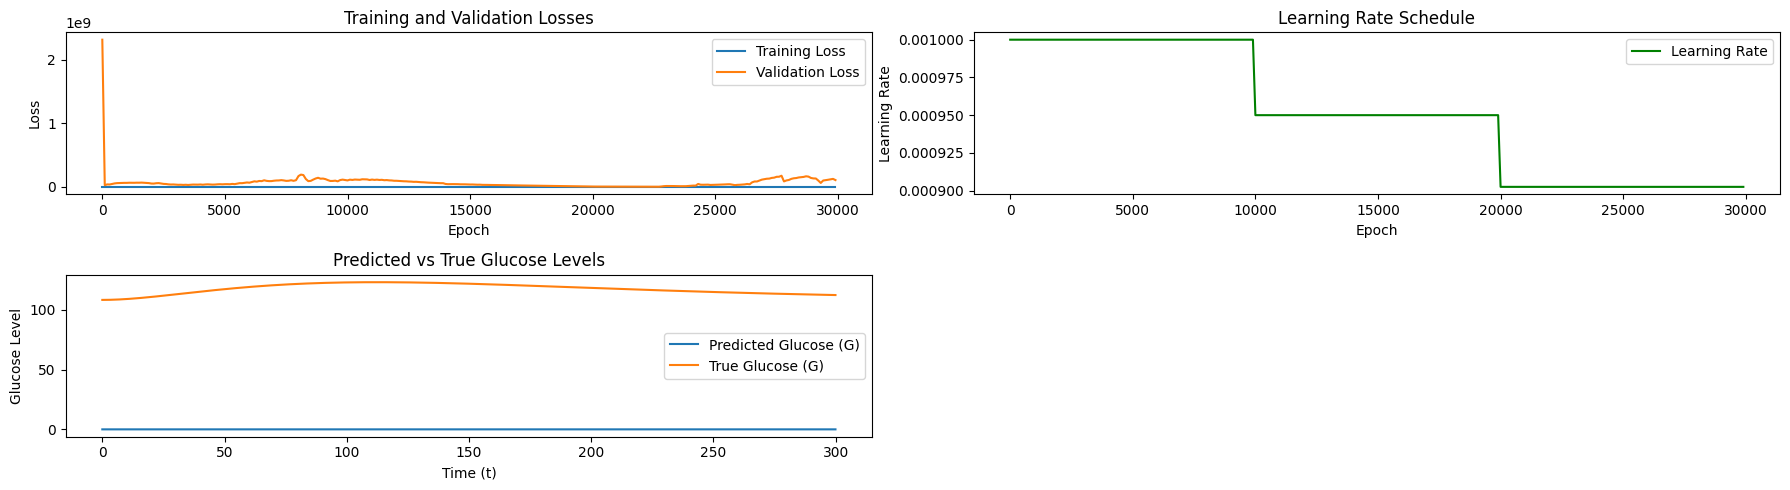

In [23]:
# Plot training and validation losses and learning rate
plt.figure(figsize=(18, 5))

# First subplot for losses
plt.subplot(2, 2, 1)
epochs = range(0, num_epoch, 100)  # Since we record losses every 100 epochs
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Second subplot for learning rate
plt.subplot(2, 2, 2)
plt.plot(epochs, learning_rates, label='Learning Rate', color='green')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()

# Third subplot for glucose predictions
plt.subplot(2, 2, 3)
t_test = torch.linspace(0, 299.9, 2500, device=device).reshape(-1, 1)
X_pred = model(t_test)
G_pred = X_pred[:, 5].detach().cpu().numpy()

# G_pred = G_pred * 454.54
G_pred = G_pred * (0.0022/1.33)
#         self.GEZI = nn.Parameter(torch.tensor([0.0022], device=device))      # [min^(-1)]
        # self.EGP_0 = nn.Parameter(torch.tensor([1.33], device=device))  

plt.plot(t_test.cpu().numpy(), G_pred, label='Predicted Glucose (G)')
plt.plot(data["t"], data["G"], label='True Glucose (G)')
plt.xlabel('Time (t)')
plt.ylabel('Glucose Level')
plt.title('Predicted vs True Glucose Levels')
plt.legend()

plt.tight_layout()
plt.show()